<a href="https://colab.research.google.com/github/anushadatar/Olin-Data-Science-SP20/blob/master/09_relationships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relationships

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

This notebook explores relationships between variables.

* We will visualize relationships using scatter plots, box plots, and violin plots,

* And we will quantify relationships using correlation and simple regression.

The most important lesson in this notebook is that you should always visualize the relationship between variables before you try to quantify it; otherwise, you are likely to be misled.

In [1]:
# Get the data file

import os

if not os.path.exists('brfss.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/brfss.hdf5

--2020-02-19 19:23:29--  https://github.com/AllenDowney/ElementsOfDataScience/raw/master/brfss.hdf5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/brfss.hdf5 [following]
--2020-02-19 19:23:29--  https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/brfss.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8007240 (7.6M) [application/octet-stream]
Saving to: ‘brfss.hdf5’

brfss.hdf5          100%[===================>]   7.64M  --.-KB/s    in 0.09s   

2020-02-19 19:23:29 (88.7 MB/s) - ‘brfss.hdf5’ saved [8007240/8007240]



In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.3.4-cp36-none-any.whl size=9201 sha256=6dcd00dbad404f5197af6c24ff1f147304171c6db0209655e9f020e4d6db8139
  Stored in directory: /root/.cache/pip/wheels/ac/73/c9/8f65a5da21549c874a85614bff3413ddc0e441b9b0c73a823b
Successfully built empiricaldist


## Exploring relationships

So far we have only looked at one variable at a time.  Now it's time to explore relationships between variables.

As a first example, we'll look at the relationship between height and weight.

I'll use data from the Behavioral Risk Factor Surveillance Survey, or BRFSS, which is run by the Centers for Disease Control.  The survey includes more than 400,000 respondents, but to keep things manageable, we'll use a random subsample of 100,000.

In [3]:
import pandas as pd

brfss = pd.read_hdf('brfss.hdf5', 'brfss')
brfss.shape

(100000, 9)

Like the NSFG, the BRFSS deliberately oversamples some groups, so each respondent has a sampling weight, stored in the `_LLCPWT` column.  I used these weights to resample the data, so the subset we just loaded is representative of adult residents of the U.S.

The BRFSS includes hundreds of variables.  For the examples in this notebook, I chose just nine.  I'll explain what the columns mean as we go along.

In [4]:
brfss.head()

,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
96230,2.0,160.0,60.33,8.0,1398.525290,6.0,2.14,150.0,47.0
244920,2.0,163.0,58.97,5.0,84.057503,13.0,3.14,160.0,89.5
57312,2.0,163.0,72.57,8.0,390.248599,5.0,2.64,160.0,42.0
32573,2.0,165.0,74.84,1.0,11566.705300,3.0,1.46,160.0,32.0
355929,2.0,170.0,108.86,3.0,844.485450,3.0,1.81,160.0,32.0


A common way to visualize the relationship between two variables is a "scatter plot".

Scatter plots are common and readily understood, but they are surprisingly hard to get right.

To demonstrate, we'll explore the relationship between height and weight.  First I'll extract the columns for height in centimeters and weight in kilograms.

In [0]:
height = brfss['HTM4']
weight = brfss['WTKG3']

To make a scatter plot we'll use `plot()` with the style string `o`, which plots a circle for each data point.

Here's how:

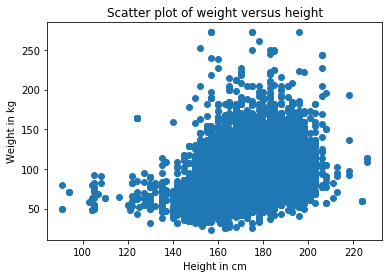

In [6]:
import matplotlib.pyplot as plt

plt.plot(height, weight, 'o')

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

In general, it looks like taller people are heavier, but there are a few things about this scatter plot that make it hard to interpret.

Most importantly, it is "overplotted", which means that there are data points piled on top of each other so you can't tell where there are a lot of points and where there is just one.

When that happens, the results can be really misleading.

One way to improve the plot is to use transparency, which we can do with the keyword argument `alpha`.  The lower the value of alpha, the more transparent each data point is.  

Here's what it looks like with `alpha=0.02`.

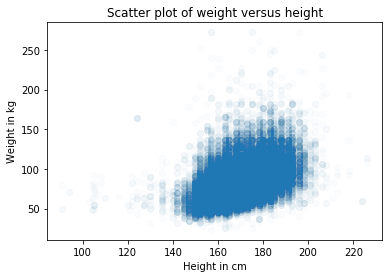

In [7]:
plt.plot(height, weight, 'o', alpha=0.02)

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

This is better, but there are so many data points, the scatter plot is still overplotted.  The next step is to make the markers smaller.

With `markersize=1` and a low value of alpha, the scatter plot is less saturated.

Here's what it looks like.

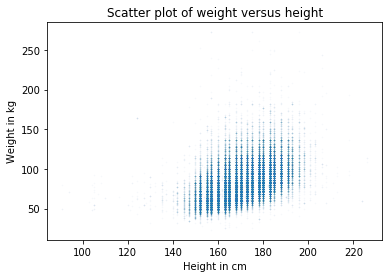

In [8]:
plt.plot(height, weight, 'o', alpha=0.02, markersize=1)

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

Again, this is better, but now we can see that the points fall in discrete columns.  That's because most heights were reported in inches and converted to centimeters.

We can break up the columns by adding some random noise to the values; in effect, we are filling in the values that got rounded off.

Adding random noise like this is called "jittering".

In this example, I added noise with mean 0 and standard deviation 2.

Here's what the plot looks like when we jitter height.

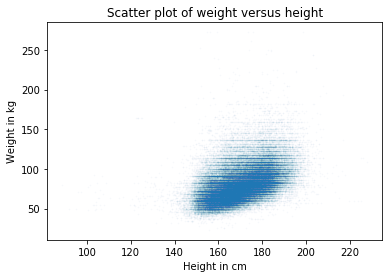

In [9]:
import numpy as np

height_jitter = height + np.random.normal(0, 2, size=len(brfss))

plt.plot(height_jitter, weight, 'o', alpha=0.02, markersize=1)

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

The columns are gone, but now we can see that there are rows where people rounded off their weight.  We can fix that by jittering weight, too.

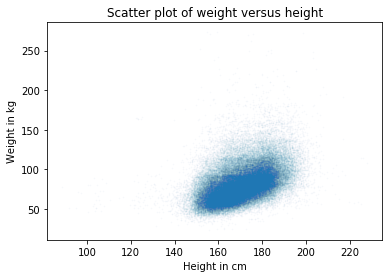

In [10]:
weight_jitter = weight + np.random.normal(0, 2, size=len(brfss))

plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

Finally, let's zoom in on the area where most of the data points are.

The Pyplot functions `xlim()` and `ylim()` set the lower and upper bounds for the x- and y-axis; in this case, we plot heights from 140 to 200 centimeters and weights up to 160 kilograms.

Here's what it looks like.

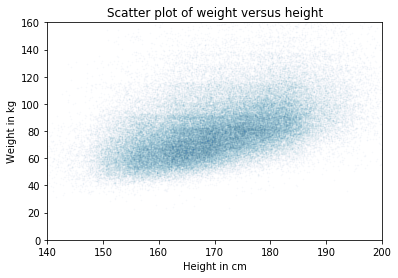

In [11]:
weight_jitter = weight + np.random.normal(0, 2, size=len(brfss))

plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

Now we have a reliable picture of the relationship between height and weight.

Below you can see the misleading plot we started with and the more reliable one we ended with.  They are clearly different, and they suggest different stories about the relationship between these variables.

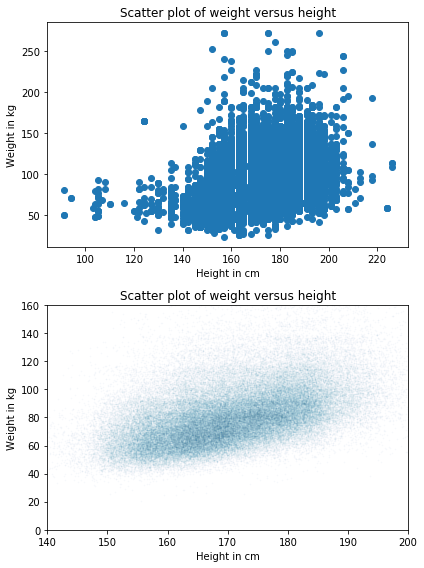

In [12]:
# Set the figure size
plt.figure(figsize=(6, 8))

# Create subplots with 2 rows, 1 column, and start plot 1
plt.subplot(2, 1, 1)
plt.plot(height, weight, 'o')

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height')

# Adjust the layout so the two plots don't overlap
plt.tight_layout()

# Start plot 2
plt.subplot(2, 1, 2)

weight_jitter = weight + np.random.normal(0, 2, size=len(brfss))

plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height')
plt.tight_layout()

The point of this example is that it takes some effort to make an effective scatter plot.

**Exercise:** Do people tend to gain weight as they get older? We can answer this question by visualizing the relationship between weight and age. 

But before we make a scatter plot, it is a good idea to visualize distributions one variable at a time. So let's look at the distribution of age.

The BRFSS dataset includes a column, `AGE`, which represents each respondent's age in years. To protect respondents' privacy, ages are rounded off into 5-year bins. `AGE` contains the midpoint of the bins.

- Extract the variable `'AGE'` from the DataFrame `brfss` and assign it to `age`.

- Plot the PMF of `age` as a bar chart.

In [0]:
from empiricaldist import Pmf

In [0]:
# Solution goes here
age = brfss['AGE']
pmf_age = Pmf.from_seq(age, normalize=True)
pmf_age.bar(label='age')

plt.xlabel('Age (years)')
plt.ylabel('PMF')
plt.title('Distribution of ages')
plt.legend();


**Exercise:** Now let's look at the distribution of weight.  The column that contains weight in kilograms is `WTKG3`.  This column contains many unique values, if we display it using a PMF, it doesn't work very well.

In [13]:
# Solution goes here
weight = brfss['WTKG3']
pmf_weight = Pmf.from_seq(weight, normalize=True)
pmf_weight.bar(label='weight')

plt.xlabel('Weight (kg)')
plt.ylabel('PMF')
plt.title('Distribution of weights')
plt.legend();


NameError: ignored

To get a better view of this distribution, try plotting the CDF.

Also try plotting it on a log-x scale.

In [0]:
from empiricaldist import Cdf

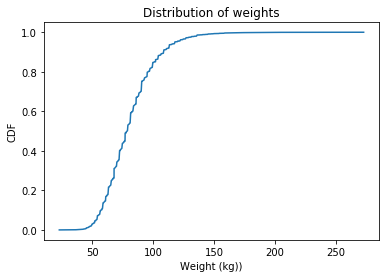

In [0]:
# Solution goes here
cdf_weight = Cdf.from_seq(weight)
cdf_weight.plot()

plt.xlabel('Weight (kg))')
plt.ylabel('CDF')
plt.title('Distribution of weights');



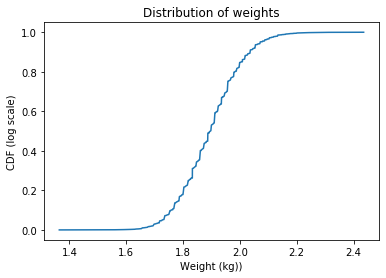

In [0]:
# Solution goes here

# Solution goes here
cdf_weight = Cdf.from_seq(np.log10(weight))
cdf_weight.plot()

plt.xlabel('Weight (kg))')
plt.ylabel('CDF (log scale)')
plt.title('Distribution of weights');



**Optional Exercise:** Compute the CDF of a normal distribution and compare it with the distribution of weight.  Is the normal distribution a good model for this data?  What about log-transformed weights?

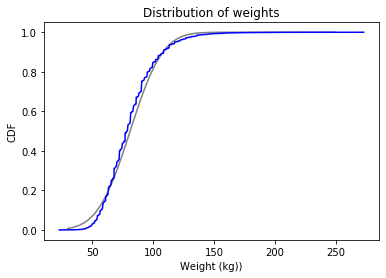

In [0]:
# standard

from scipy.stats import norm

mean = weight.mean()
stdev = weight.std()
xs = np.linspace(30, 250)
dist = norm(loc=mean, scale=stdev).cdf(xs)
plt.plot(xs, dist, color='gray', label='Normal CDF')

cdf_weight = Cdf.from_seq(weight)
cdf_weight.plot(color='blue', label='Weights')

plt.xlabel('Weight (kg))')
plt.ylabel('CDF')
plt.title('Distribution of weights');


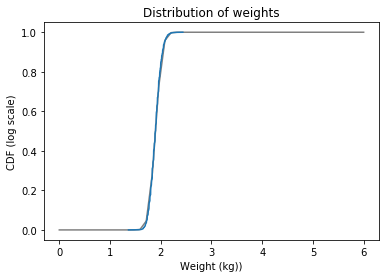

In [0]:
# Log-Transformed

from scipy.stats import norm

log_weight = np.log10(weight)
log_mean = log_weight.mean()
log_std = log_weight.std()
log_xs = np.linspace(0, 6)
dist_xs = norm(loc=log_mean, scale=log_std).cdf(log_xs)
plt.plot(log_xs, dist_xs, color='gray', label='Normal CDF')

cdf_log_weight = Cdf.from_seq(log_weight)
cdf_log_weight.plot()

plt.xlabel('Weight (kg))')
plt.ylabel('CDF (log scale)')
plt.title('Distribution of weights');

income_dist = np.linspace(0, 6)
dist = norm(loc=mean, scale=stdev).cdf(income_dist)


# The log is a better model!

**Exercise:** Now let's make a scatter plot of `weight` versus `age`.  Adjust `alpha` and `markersize` to avoid overplotting.  Use `ylim` to limit the `y` axis from 0 to 200 kilograms.

(0, 200)

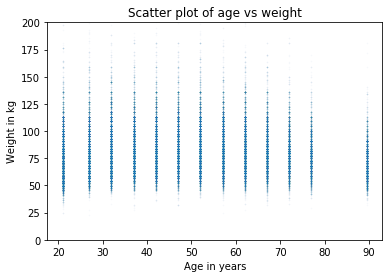

In [0]:
# Solution goes here

import matplotlib.pyplot as plt

plt.plot(age, weight, 'o', markersize=1, alpha=0.02)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of age vs weight');
plt.ylim(0, 200)

**Exercise:** In the previous exercise, the ages fall in columns because they've been rounded into 5-year bins. If we jitter them, the scatter plot will show the relationship more clearly.

- Add random noise to `age` with mean `0` and standard deviation `2.5`.
- Make a scatter plot and adjust `alpha` and `markersize` again.

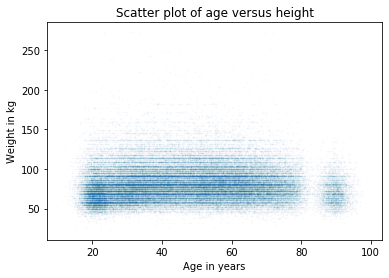

In [0]:
# Solution goes here

age_jitter = age + np.random.normal(0, 2.5, size=len(brfss))

plt.plot(age_jitter, weight, 'o', alpha=0.02, markersize=1)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of age versus height');

## Visualizing relationships

In the previous section we used scatter plots to visualize relationships between variables, and in the exercises, you explored the relationship between age and weight.  In this section, we'll see other ways to visualize these relationships, including boxplots and violin plots.

In a previous exercise, you made a scatter plot of weight versus age that might have looked like this:

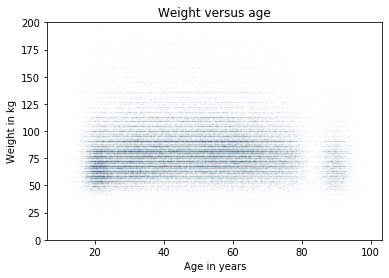

In [0]:
# Add jittering to age
age_jitter = age + np.random.normal(0, 2.5, size=len(brfss))

# Make a scatter plot
plt.plot(age_jitter, weight, 'o', alpha=0.01, markersize=1)

# Decorate the axes
plt.ylim([0, 200])
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

It looks like older people might be heavier, but it is hard to see clearly.

Here's another version of the same plot:

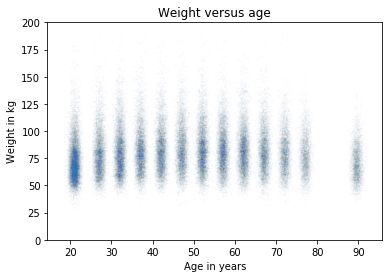

In [0]:
# Jitter weight
weight = brfss['WTKG3'] + np.random.normal(0, 2, size=len(brfss))

# Jitter age
age_jitter = age + np.random.normal(0, 0.75, size=len(brfss))

# Make a scatter plot
plt.plot(age_jitter, weight_jitter, 'o', alpha=0.01, markersize=1)

# Decorate the axes
plt.ylim([0, 200])
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

Here's what I changed:

* First, I jittered the weights, so the horizontal rows are not visible.

* Second, I adjusted the jittering of the weights so there's still space between the columns.

That makes it possible to see the shape of the distribution in each age group, and the differences between groups.

With this view, it looks like weight increases until age 40 or 50, and then starts to decrease.

If we take this idea one step farther, we can use KDE to estimate the density function in each column and plot it.

And there's a name for that; it's called a violin plot.  Seaborn provides a function that makes violin plots, but before we can use it, we have to get rid of any rows with missing data.

Here's how:

In [0]:
brfss.shape

(100000, 9)

In [0]:
data = brfss.dropna(subset=['AGE', 'WTKG3'])
data.shape

(92729, 9)

`dropna()` creates a new DataFrame that contains the rows from `brfss` where `AGE` and `WTKG3` are not NaN.

Now we can call `violinplot()`.

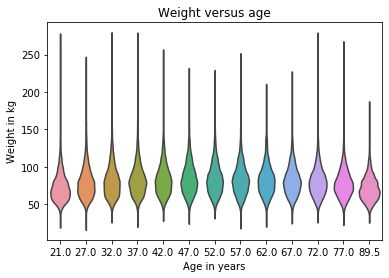

In [0]:
import seaborn as sns

sns.violinplot(x='AGE', y='WTKG3', data=data, inner=None)

# Decorate the axes
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

The `x` and `y` arguments mean we want `AGE` on the x-axis and `WTKG3` on the y-axis.  `data` is the DataFrame we just created, which contains the variables we're going to plot.  The argument `inner=None` simplifies the plot a little.

In the figure, each shape represents the distribution of weight in one age group.  The width of these shapes is proportional to the estimated density, so it's like two vertical KDEs plotted back to back (and filled in with nice colors).

There's yet another way to look at data like this, called a "box plot".  The code to generate a box plot is very similar.  

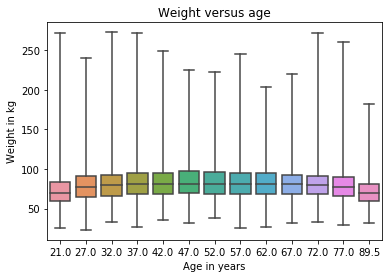

In [0]:
sns.boxplot(x='AGE', y='WTKG3', data=data, whis=10)

# Decorate the axes
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

I included the argument `whis=10` to turn off a feature we don't need.  If you are curious about it, you can read the documentation.

Each box represents the distribution of weight in an age group.  The height of each box represents the range from the 25th to the 75th percentile.  The line in the middle of each box is the median.

The spines sticking out of the top and bottom show the minimum and maximum values.

In my opinion, this plot gives us the best view of the relationship between weight and age.

Looking at the medians, it seems like people in their 40s are the heaviest; younger and older people are lighter.

Looking at the sizes of the boxes, it seems like people in their 40s have the most variability in weight, too.

These plots also show how skewed the distribution of weight is; that is, the heaviest people are much farther from the median than the lightest people.

For data that skews toward higher values, it is sometimes useful to look at it on a logarithmic scale.

We can do that with the Pyplot function `yscale()`.

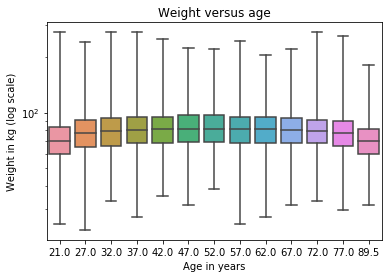

In [0]:
sns.boxplot(x='AGE', y='WTKG3', data=data, whis=10)

# Decorate the axes
plt.yscale('log')
plt.xlabel('Age in years')
plt.ylabel('Weight in kg (log scale)')
plt.title('Weight versus age');

Here's what it looks like.  To show the relationship between age and weight most clearly, this is probably the figure I would use.

In the exercises, you'll have a chance to generate violin and box plots.

**Exercise:** Previously we looked at a scatter plot of height and weight, and saw that taller people tend to be heavier.  Now let's take a closer look using a box plot. The `brfss` DataFrame contains a column named `_HTMG10` that represents height in centimeters, binned into 10 cm groups.

- Make a boxplot that shows the distribution of weight in each height group.

- Plot the y-axis on a logarithmic scale.

Suggestion: If the labels on the `x` axis collide, you can rotate them like this:

```
plt.xticks(rotation='45')
```

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

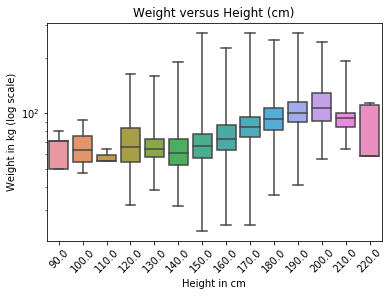

In [0]:
# Solution goes here
sns.boxplot(x='_HTMG10', y='WTKG3', data=data, whis=10)

# Decorate the axes
plt.yscale('log')
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg (log scale)')
plt.title('Weight versus Height (cm)')
plt.xticks(rotation='45')


**Exercise:** Now let's look at relationships between income and other variables.  

In the BRFSS, income is represented as a categorical variable; that is, respondents are assigned to one of 8 income categories.  The column name is `INCOME2`.  

Before we connect income with anything else, let's look at the distribution by computing the PMF.

- Extract `INCOME2` from the `brfss` DataFrame and assign it to `income`.
- Plot the PMF of `income` as a bar chart.

Note: You will see that about a third of the respondents are in the highest income group; ideally, it would be better if there were more groups at the high end, but we'll work with what we have.

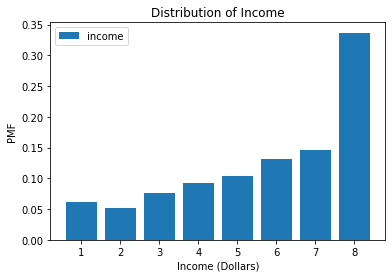

In [0]:
# Solution goes here
income = brfss['INCOME2']
pmf_income = Pmf.from_seq(income, normalize=True)
pmf_income.bar(label='income')

plt.xlabel('Income (Bracket)')
plt.ylabel('PMF')
plt.title('Distribution of Income')
plt.legend();

**Exercise:** Generate a violin plot that shows the distribution of height in each income group.  Can you see a relationship between these variables?

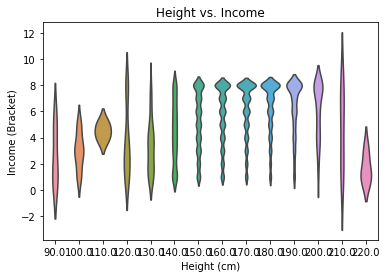

In [0]:
# Solution goes here

sns.violinplot(x='_HTMG10', y='INCOME2', data=data, inner=None)

# Decorate the axes
plt.xlabel('Height (cm)')
plt.ylabel('Income (Bracket)')
plt.title('Height vs. Income');

# Slight relationship where somewhat tall people are higher-income. 


## Correlation

In the previous lesson, we visualized relationships between pairs of variables.  In this lesson we'll learn about the coefficient of correlation, which quantifies the strength of these relationships.

When people say "correlation" casually, they might mean any relationship between two variables.  In statistics, it usually means Pearson's correlation coefficient, which is a number between -1 and 1 that quantifies the strength of a linear relationship between variables.

To demonstrate, I'll select three columns from the BRFSS dataset, like this.  The result is a DataFrame with just those columns.

In [0]:
columns = ['HTM4', 'WTKG3', 'AGE']
subset = brfss[columns]

Now we can use the `.corr()` method, like this.

In [0]:
subset.corr()

,HTM4,WTKG3,AGE
HTM4,1.000000,0.474203,-0.093684
WTKG3,0.474203,1.000000,0.021641
AGE,-0.093684,0.021641,1.000000


The result is a "correlation matrix".  Reading across the first row, the correlation of `HTM4` with itself is 1.  That's expected; the correlation of anything with itself is 1.

The next entry is more interesting; the correlation of height and weight is about 0.47.  It's positive, which means taller people are heavier, and it is moderate in strength, which means it has some predictive value.  If you know someone's height, you can make a better guess about their weight, and vice versa.

The correlation between height and age is about -0.09.  It's negative, which means that older people tend to be shorter, but it's weak, which means that knowing someone's age would not help much if you were trying to guess their height.

The correlation between age and weight is even smaller.  It is tempting to conclude that there is no relationship between age and weight, but we have already seen that there is.  So why is the correlation so low?

Remember that the relationship between weight and age looks like this. 

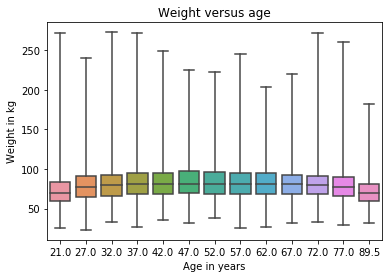

In [0]:
data = brfss.dropna(subset=['AGE', 'WTKG3'])
sns.boxplot(x='AGE', y='WTKG3', data=data, whis=10)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

 

People in their 40s are the heaviest; younger and older people are lighter.  So this relationship is nonlinear.

But correlation only measures linear relationships.  If the relationship is nonlinear, correlation generally underestimates how strong it is.

To demonstrate, I'll generate some fake data: `xs` contains equally-spaced points between -1 and 1.  `ys` is `xs` squared plus some random noise.

In [0]:
np.random.seed(18)
xs = np.linspace(-1, 1)
ys = xs**2 + np.random.normal(0, 0.05, len(xs))

Here's the scatter plot of `xs` and `ys`.  

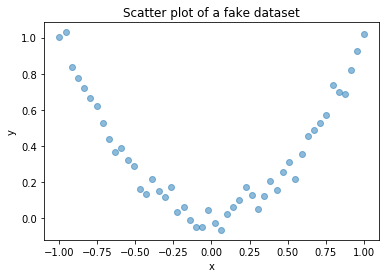

In [0]:
plt.plot(xs, ys, 'o', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of a fake dataset');

It's clear that this is a strong relationship; if you are given `x`, you can make a much better guess about `y`.

But here's the correlation matrix:

In [0]:
np.corrcoef(xs, ys)

array([[ 1.        , -0.01101448],
       [-0.01101448,  1.        ]])

Even though there is a strong non-linear relationship, the computed correlation is close to 0.

In general, if correlation is high -- that is, close to 1 or -1, you can conclude that there is a strong linear relationship.

But if correlation is close to 0, that doesn't mean there is no relationship; there might be a non-linear relationship.

This is one of the reasons I think correlation is not such a great statistic.

There's another reason to be careful with correlation; it doesn't mean what people take it to mean.

Specifically, correlation says nothing about slope.  If we say that two variables are correlated, that means we can use one to predict the other.  But that might not be what we care about.

For example, suppose we are concerned about the health effects of weight gain, so we plot weight versus age, from 20 to 50 years old.

I'll generate two fake datasets to demonstrate the point.

In each dataset, `xs` represents age and `ys` represents weight.

I use `np.random.seed` to initialize the random number generator so we get the same results every time we run.

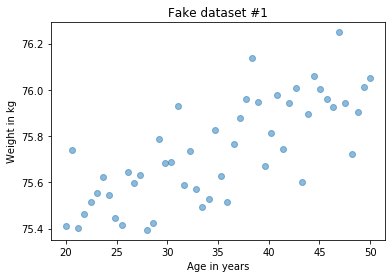

In [0]:
np.random.seed(18)
xs1 = np.linspace(20, 50)
ys1 = 75 + 0.02 * xs1 + np.random.normal(0, 0.15, len(xs1))

plt.plot(xs1, ys1, 'o', alpha=0.5)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Fake dataset #1');

And here's the second dataset:

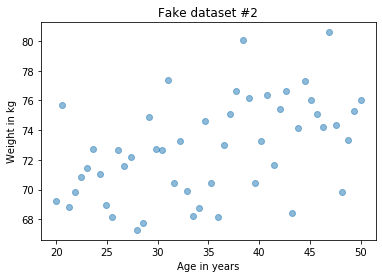

In [0]:
np.random.seed(18)
xs2 = np.linspace(20, 50)
ys2 = 65 + 0.2 * xs2 + np.random.normal(0, 3, len(xs2))

plt.plot(xs2, ys2, 'o', alpha=0.5)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Fake dataset #2');

I constructed these examples so they look similar, but they have substantially different correlations: 

In [0]:
rho1 = np.corrcoef(xs1, ys1)[0][1]
rho1

0.7579660563439401

In [0]:
rho2 = np.corrcoef(xs2, ys2)[0][1]
rho2

0.4782776976576317

In the first example, the correlation is strong, close to 0.75.

In the second example, the correlation is moderate, close to 0.5.

So we might thing the first relationship is more important.  But look more closely at the `y` axis in both figure.

In the first example, the average weight gain over 30 years is less than 1 kilogram; in the second it more than 5 kilograms!

If we are concerned about the health effects of weight gain, the second relationship is probably more important, even though the correlation is lower.  

The statistic we really care about is the slope of the line, not to coefficient of correlation.

In the next lesson, you'll learn how to estimate that slope.  But first, let's practice with correlation.

**Exercise:** The purpose of the BRFSS is to explore health risk factors, so it includes questions about diet.  The column `_VEGESU1` represents the number of servings of vegetables respondents reported eating per day.

Let's see how this variable relates to age and income.

- From the `brfss` DataFrame, select the columns `'AGE'`, `INCOME2`, and `_VEGESU1`.
- Compute the correlation matrix for these variables.

In [0]:
# Solution goes here
columns = ['AGE', 'INCOME2', '_VEGESU1']
subset = brfss[columns]
subset.corr()

,AGE,INCOME2,_VEGESU1
AGE,1.000000,-0.015158,-0.009834
INCOME2,-0.015158,1.000000,0.119670
_VEGESU1,-0.009834,0.119670,1.000000


**Exercise:** In the previous exercise, the correlation between income and vegetable consumption is about `0.12`.  The correlation between age and vegetable consumption is about `-0.01`.

Which of the following are correct interpretations of these results:

- *A*: People in this dataset with higher incomes eat more vegetables.
- *B*: The relationship between income and vegetable consumption is linear.
- *C*: Older people eat more vegetables.
- *D*: There could be a strong non-linear relationship between age and vegetable consumption.

In [0]:
# Solution goes here
# D is a correct interpretation. 

**Exercise:** In general it is a good idea to visualize the relationship between variables *before* you compute a correlation.  We didn't do that in the previous example, but it's not too late.

Generate a visualization of the relationship between age and vegetables.  How would you describe the relationship, if any?

Text(0.5, 1.0, 'Relationship between age and vegetable consumption')

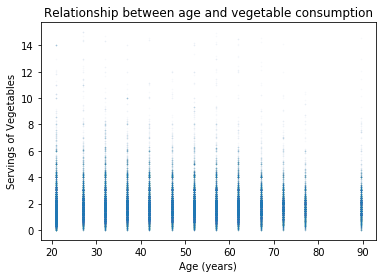

In [0]:
# Solution goes here
plt.plot(brfss['AGE'], brfss['_VEGESU1'], 'o', alpha=0.02, markersize=1)
plt.xlabel("Age (years)")
plt.ylabel("Servings of Vegetables")
plt.title("Relationship between age and vegetable consumption")
# There is no strong relationship, young people might eat slightly more vegetables.

## Simple regression

In the previous section we saw that correlation does not always measure what we really want to know.  In this section, we look at an alternative: simple linear regression.

Let's look again at the Fake dataset relationship between weight and age.  In the previous section, I generated two fake datasets to make a point:

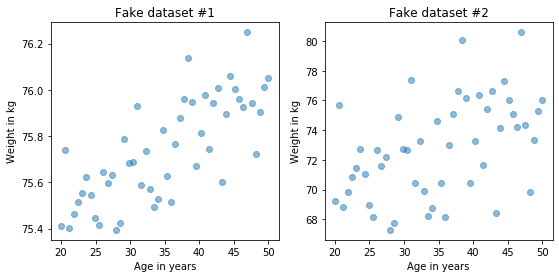

In [0]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(xs1, ys1, 'o', alpha=0.5)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Fake dataset #1')

plt.subplot(1, 2, 2)
plt.plot(xs2, ys2, 'o', alpha=0.5)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Fake dataset #2');

They look similar, and one on the left has higher correlation, about 0.75 compared to 0.5.

But in this context, the statistic we probably care about is the slope of the line, not the correlation coefficient.

To estimate the slope, we can use `linregress()` from the SciPy stats module.

In [0]:
from scipy.stats import linregress

# Fake dataset 1
res1 = linregress(xs1, ys1)
res1

LinregressResult(slope=0.018821034903244386, intercept=75.08049023710964, rvalue=0.7579660563439402, pvalue=1.8470158725246148e-10, stderr=0.002337849260560818)

The result is a `LinRegressResult` that contains five values: `slope` is the slope of the line of best fit for the data; `intercept` is the intercept.

For Fake dataset #1, the estimated slope is about 0.019 kilograms per year or about 0.56 kilograms over the 30-year range.

In [0]:
res1.slope * 30

0.5646310470973316

Here are the results for Fake dataset #2.  

In [0]:
res2 = linregress(xs2, ys2)
res2

LinregressResult(slope=0.17642069806488855, intercept=66.60980474219305, rvalue=0.47827769765763173, pvalue=0.0004430600283776241, stderr=0.04675698521121631)

The estimated slope is about 10 times higher: about 0.18 kilograms per year or about 5.3 kilograms per 30 years:

In [0]:
res2.slope * 30

5.292620941946657

What's called `rvalue` here is correlation, which confirms what we saw before; the first example has higher correlation, about 0.75 compared to 0.5.

But the strength of the effect, as measured by the slope of the line, is about 10 times higher in the second example.

We can use the results from `linregress()` to compute the line of best fit: first we get the min and max of the observed xs; then we multiply by the slope and add the intercept.  And plot the line.

Here's what that looks like for the first example.  

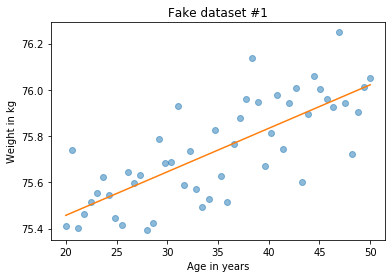

In [0]:
plt.plot(xs1, ys1, 'o', alpha=0.5)

fx = np.array([xs1.min(), xs1.max()])
fy = res1.intercept + res1.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Fake dataset #1');

And the same thing for the second example.  

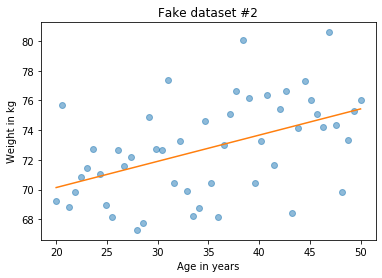

In [0]:
plt.plot(xs2, ys2, 'o', alpha=0.5)

fx = np.array([xs2.min(), xs2.max()])
fy = res2.intercept + res2.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Fake dataset #2');

The visualization here might be misleading unless you look closely at the vertical scales; the slope on the right is almost 10 times higher.

## Height and weight

Now let's look at an example with real data.

Here's the scatter plot of height and weight one more time.

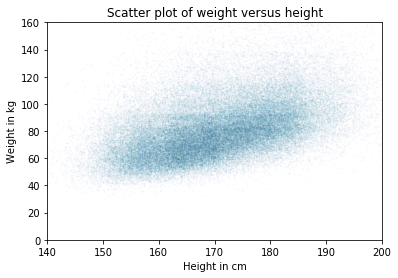

In [0]:
plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

Now we can compute the regression line.  `linregress()` can't handle NaNs, so we have to use `dropna()` to remove rows that are missing the data we need.

In [0]:
subset = brfss.dropna(subset=['WTKG3', 'HTM4'])

height_clean = subset['HTM4']
weight_clean = subset['WTKG3']

Now we can compute the linear regression.

In [0]:
res_hw = linregress(height_clean, weight_clean)
res_hw

LinregressResult(slope=0.9192115381848305, intercept=-75.12704250330248, rvalue=0.4742030897902462, pvalue=0.0, stderr=0.005632863769802998)

And here are the results.  The slope is about 0.9 kilograms per centimeter, which means that we expect a person one centimeter taller to be almost a kilogram heavier.  That's quite a lot.

As before, we can compute the line of best fit:

In [0]:
fx = np.array([height_clean.min(), height_clean.max()])
fy = res_hw.intercept + res_hw.slope * fx

And here's what that looks like.  

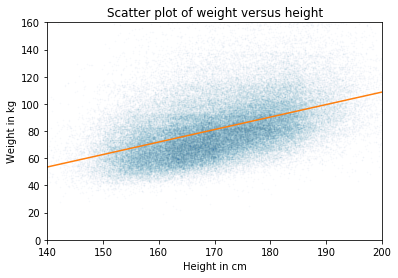

In [0]:
plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.plot(fx, fy, '-')

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

The slope of this line seems consistent with the scatter plot.

However, linear regression has the same problem as correlation; it only measures the strength of a linear relationship.

Here's the scatter plot of weight versus age, which you saw in a previous exercise.

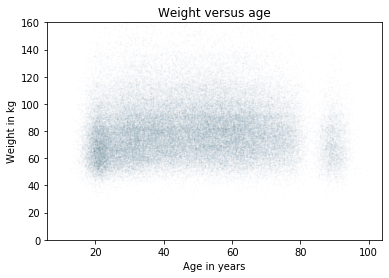

In [0]:
# Add jittering to age
age_jitter = age + np.random.normal(0, 2.5, size=len(brfss))

# Make a scatter plot
plt.plot(age_jitter, weight, 'o', alpha=0.01, markersize=1)

plt.ylim([0, 160])
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

People in their 40s are the heaviest; younger and older people are lighter.  So the relationship is nonlinear.

If we don't look at the scatter plot and blindly compute the regression line, here's what we get.

In [0]:
subset = brfss.dropna(subset=['WTKG3', 'AGE'])
age_clean = subset['AGE']
weight_clean = subset['WTKG3']

res_aw = linregress(age_clean, weight_clean)
res_aw

LinregressResult(slope=0.023981159566968734, intercept=80.07977583683224, rvalue=0.02164143288906408, pvalue=4.374327493007456e-11, stderr=0.003638139410742185)

The estimated slope is only 0.02 kilograms per year, or 0.6 kilograms in 30 years.

And here's what the line of best fit looks like.

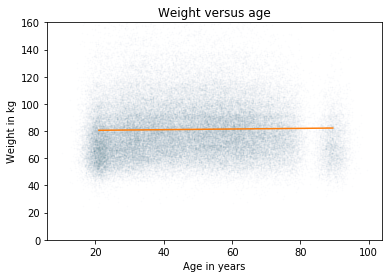

In [0]:
# Make a scatter plot
plt.plot(age_jitter, weight, 'o', alpha=0.01, markersize=1)

# Plot the line of best fit
fx = np.array([age_clean.min(), age_clean.max()])
fy = res_aw.intercept + res_aw.slope * fx
plt.plot(fx, fy, '-')

plt.ylim([0, 160])
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.title('Weight versus age');

A straight line does not capture the relationship between these variables well.

In the next notebook, you'll see how to use multiple regression to estimate non-linear relationships.  But first, let's practice simple regression.

**Exercise:** Who do you think eats more vegetables, people with low income, or people with high income?  Let's find out.

As we've seen previously, the column `INCOME2` represents income level and `_VEGESU1` represents the number of vegetable servings respondents reported eating per day.

Make a scatter plot with vegetable servings versus income, that is, with vegetable servings on the `y` axis and income group on the `x` axis.

You might want to use `ylim` to zoom in on the bottom half of the `y` axis.

(0, 9)

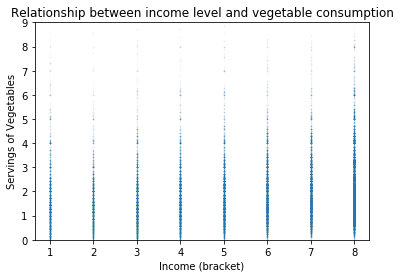

In [0]:
# Solution goes here
# Solution goes here
plt.plot(brfss['INCOME2'], brfss['_VEGESU1'], 'o', alpha=0.02, markersize=1)
plt.xlabel("Income (bracket)")
plt.ylabel("Servings of Vegetables")
plt.title("Relationship between income level and vegetable consumption")
plt.ylim(0, 9)

**Exercise:** Now let's estimate the slope of the relationship between vegetable consumption and income.

- Use `dropna` to select rows where `INCOME2` and `_VEGESU1` are not NaN.

- Extract `INCOME2` and `_VEGESU1` and compute the simple linear regression of these variables.

What is the slope of the regression
line?  Write a sentence that explains what this slope means in the context of the question we are exploring.

In [0]:
# Solution goes here
subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
income_clean = subset['INCOME2']
veg_clean = subset['_VEGESU1']

reg = linregress(income_clean, veg_clean)
reg

LinregressResult(slope=0.06988048092105019, intercept=1.5287786243363106, rvalue=0.11967005884864107, pvalue=1.378503916247615e-238, stderr=0.002110976356332332)

In [0]:
# Slope is 0.07.
# Folks in higher income groups (on average) tend to eat slightly more vegetables
# than those in lower income groups (on average).

**Exercise:** Finally, plot the regression line on top of the scatter plot.


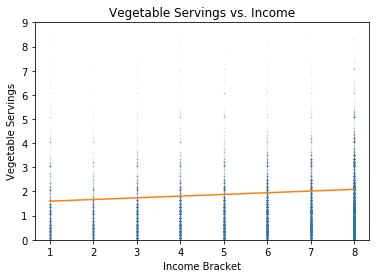

In [0]:
# Solution goes here
veg_jitter = veg_clean + np.random.normal(0, veg_clean.std())
plt.plot(income_clean, veg_jitter, 'o', alpha=0.01, markersize=1)

# Plot the line of best fit
fx = np.array([income_clean.min(), income_clean.max()])
fy = reg.intercept + reg.slope * fx
plt.plot(fx, fy, '-')

plt.ylim([0, 9])
plt.xlabel('Income Bracket')
plt.ylabel('Vegetable Servings')
plt.title('Vegetable Servings vs. Income');